## Sentiment Analysis in Keras using Attention Mechanism on Yelp Reviews Dataset

We use 200,000 Yelp Reviews from the dataset available on: https://www.yelp.com/dataset

(We took it from here: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_review.json

Don't mention this xD

In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

# Reference Yelp reviews json dataset: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_review.json 
review_json_path = r'C:\Users\Dell\Desktop\yelp_academic_dataset_review.json'

size = 200000
review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int}, nrows=size)

df_review_text=review[['stars','text']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_review_text

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
...,...,...
199995,5,Oakley's Bistro is a hidden gem for Indianapol...
199996,5,"Let me just say, I'm glad my husband and I dec..."
199997,5,I was coming back from the Farmers market toda...
199998,5,Absolutely perfect meal for me. The food is cl...


In [ ]:
num_missing_text = np.sum(df_review_text['text'].isnull())
print('num missing text: {}'.format(num_missing_text))

num missing text: 0


<AxesSubplot:>

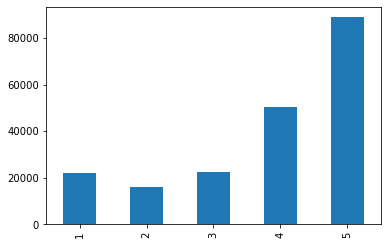

In [ ]:
df_review_text['stars'].value_counts(dropna=False).sort_index().plot(kind='bar')

In [ ]:
df_review_text['text'].iloc[0]

"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."

In [ ]:
df_review_text['sentiment'] = np.where(df_review_text['stars'] > 3, 1, 0)

print('{:.2f}% are positive reviews'.format(df_review_text['sentiment'].mean()*100))

df_review_text

69.66% are positive reviews


C:\Users\Dell\AppData\Local\Temp\ipykernel_15688\2684931072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review_text['sentiment'] = np.where(df_review_text['stars'] > 3, 1, 0)


,stars,text,sentiment
0,3,"If you decide to eat here, just be aware it is...",0
1,5,I've taken a lot of spin classes over the year...,1
2,3,Family diner. Had the buffet. Eclectic assortm...,0
3,5,"Wow! Yummy, different, delicious. Our favo...",1
4,4,Cute interior and owner (?) gave us tour of up...,1
...,...,...,...
199995,5,Oakley's Bistro is a hidden gem for Indianapol...,1
199996,5,"Let me just say, I'm glad my husband and I dec...",1
199997,5,I was coming back from the Farmers market toda...,1
199998,5,Absolutely perfect meal for me. The food is cl...,1


In [ ]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df_review_text['Processed_Reviews'] = df_review_text.text.apply(lambda x: clean_text(x))
df_review_text.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_15688\2999117604.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review_text['Processed_Reviews'] = df_review_text.text.apply(lambda x: clean_text(x))


,stars,text,sentiment,Processed_Reviews
0,3,"If you decide to eat here, just be aware it is...",0,decide eat aware go take 2 hour begin end try ...
1,5,I've taken a lot of spin classes over the year...,1,ive take lot spin class year nothing compare c...
2,3,Family diner. Had the buffet. Eclectic assortm...,0,family diner buffet eclectic assortment large ...
3,5,"Wow! Yummy, different, delicious. Our favo...",1,wow yummy different delicious favorite lam...
4,4,Cute interior and owner (?) gave us tour of up...,1,cute interior owner give u tour upcoming pati...


In [ ]:
df_review_text.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

56.62894

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_review_text, test_size=0.01)

MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df_train['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df_train['Processed_Reviews'])

RNN_CELL_SIZE = 32

MAX_LEN = 60   # Since our mean length is 56.6
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = df_train['sentiment']

In [ ]:
df_review_text

,stars,text,sentiment,Processed_Reviews
0,3,"If you decide to eat here, just be aware it is...",0,decide eat aware go take 2 hour begin end try ...
1,5,I've taken a lot of spin classes over the year...,1,ive take lot spin class year nothing compare c...
2,3,Family diner. Had the buffet. Eclectic assortm...,0,family diner buffet eclectic assortment large ...
3,5,"Wow! Yummy, different, delicious. Our favo...",1,wow yummy different delicious favorite lam...
4,4,Cute interior and owner (?) gave us tour of up...,1,cute interior owner give u tour upcoming pati...
...,...,...,...,...
199995,5,Oakley's Bistro is a hidden gem for Indianapol...,1,oakley bistro hide gem indianapolis chef amaz...
199996,5,"Let me just say, I'm glad my husband and I dec...",1,let say im glad husband decide wait 20 minute ...
199997,5,I was coming back from the Farmers market toda...,1,wa come back farmer market today decide stop t...
199998,5,Absolutely perfect meal for me. The food is cl...,1,absolutely perfect meal food clean good qualit...


In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      768000      ['input_1[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 60, 64)       41216       ['embedding[0][0]']              
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 60, 64),     24832       ['bi_lstm_0[0][0]']              
                                 (None, 32),                                                  

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
1584/1584 [==============================] - 160s 96ms/step - loss: 0.2875 - tp: 103624.0000 - fp: 12229.0000 - tn: 35881.0000 - fn: 6666.0000 - accuracy: 0.8807 - precision: 0.8944 - recall: 0.9396 - auc: 0.9360 - val_loss: 0.2519 - val_tp: 26140.0000 - val_fp: 2669.0000 - val_tn: 9321.0000 - val_fn: 1470.0000 - val_accuracy: 0.8955 - val_precision: 0.9074 - val_recall: 0.9468 - val_auc: 0.9518
Epoch 2/5
1584/1584 [==============================] - 152s 96ms/step - loss: 0.2380 - tp: 104653.0000 - fp: 9758.0000 - tn: 38352.0000 - fn: 5637.0000 - accuracy: 0.9028 - precision: 0.9147 - recall: 0.9489 - auc: 0.9562 - val_loss: 0.2442 - val_tp: 25917.0000 - val_fp: 2288.0000 - val_tn: 9702.0000 - val_fn: 1693.0000 - val_accuracy: 0.8995 - val_precision: 0.9189 - val_recall: 0.9387 - val_auc: 0.9542
Epoch 3/5
1584/1584 [==============================] - 154s 97ms/step - loss: 0.2119 - tp: 105256.0000 - fp: 8584.0000 - tn: 39526.0000 - fn: 5034.0000 - accuracy: 0.9140 - precision:

In [ ]:
y_test=df_test['sentiment']

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df_test['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df_test['Processed_Reviews'])

X_test = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)

In [ ]:
prediction = model.predict(X_test)

63/63 [==============================] - 3s 14ms/step


In [ ]:
y_pred = (prediction > 0.5)

              precision    recall  f1-score   support

           0       0.33      0.30      0.31       586
           1       0.72      0.75      0.73      1414

    accuracy                           0.62      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.60      0.62      0.61      2000



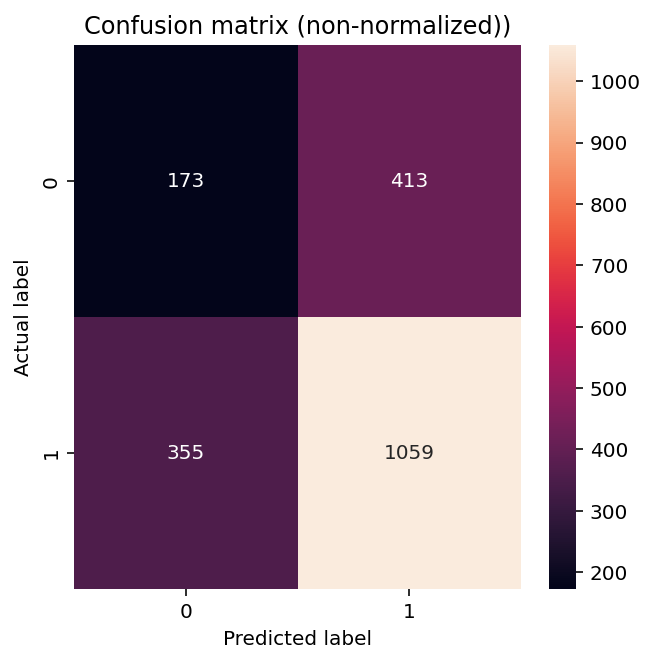

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, y_pred)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

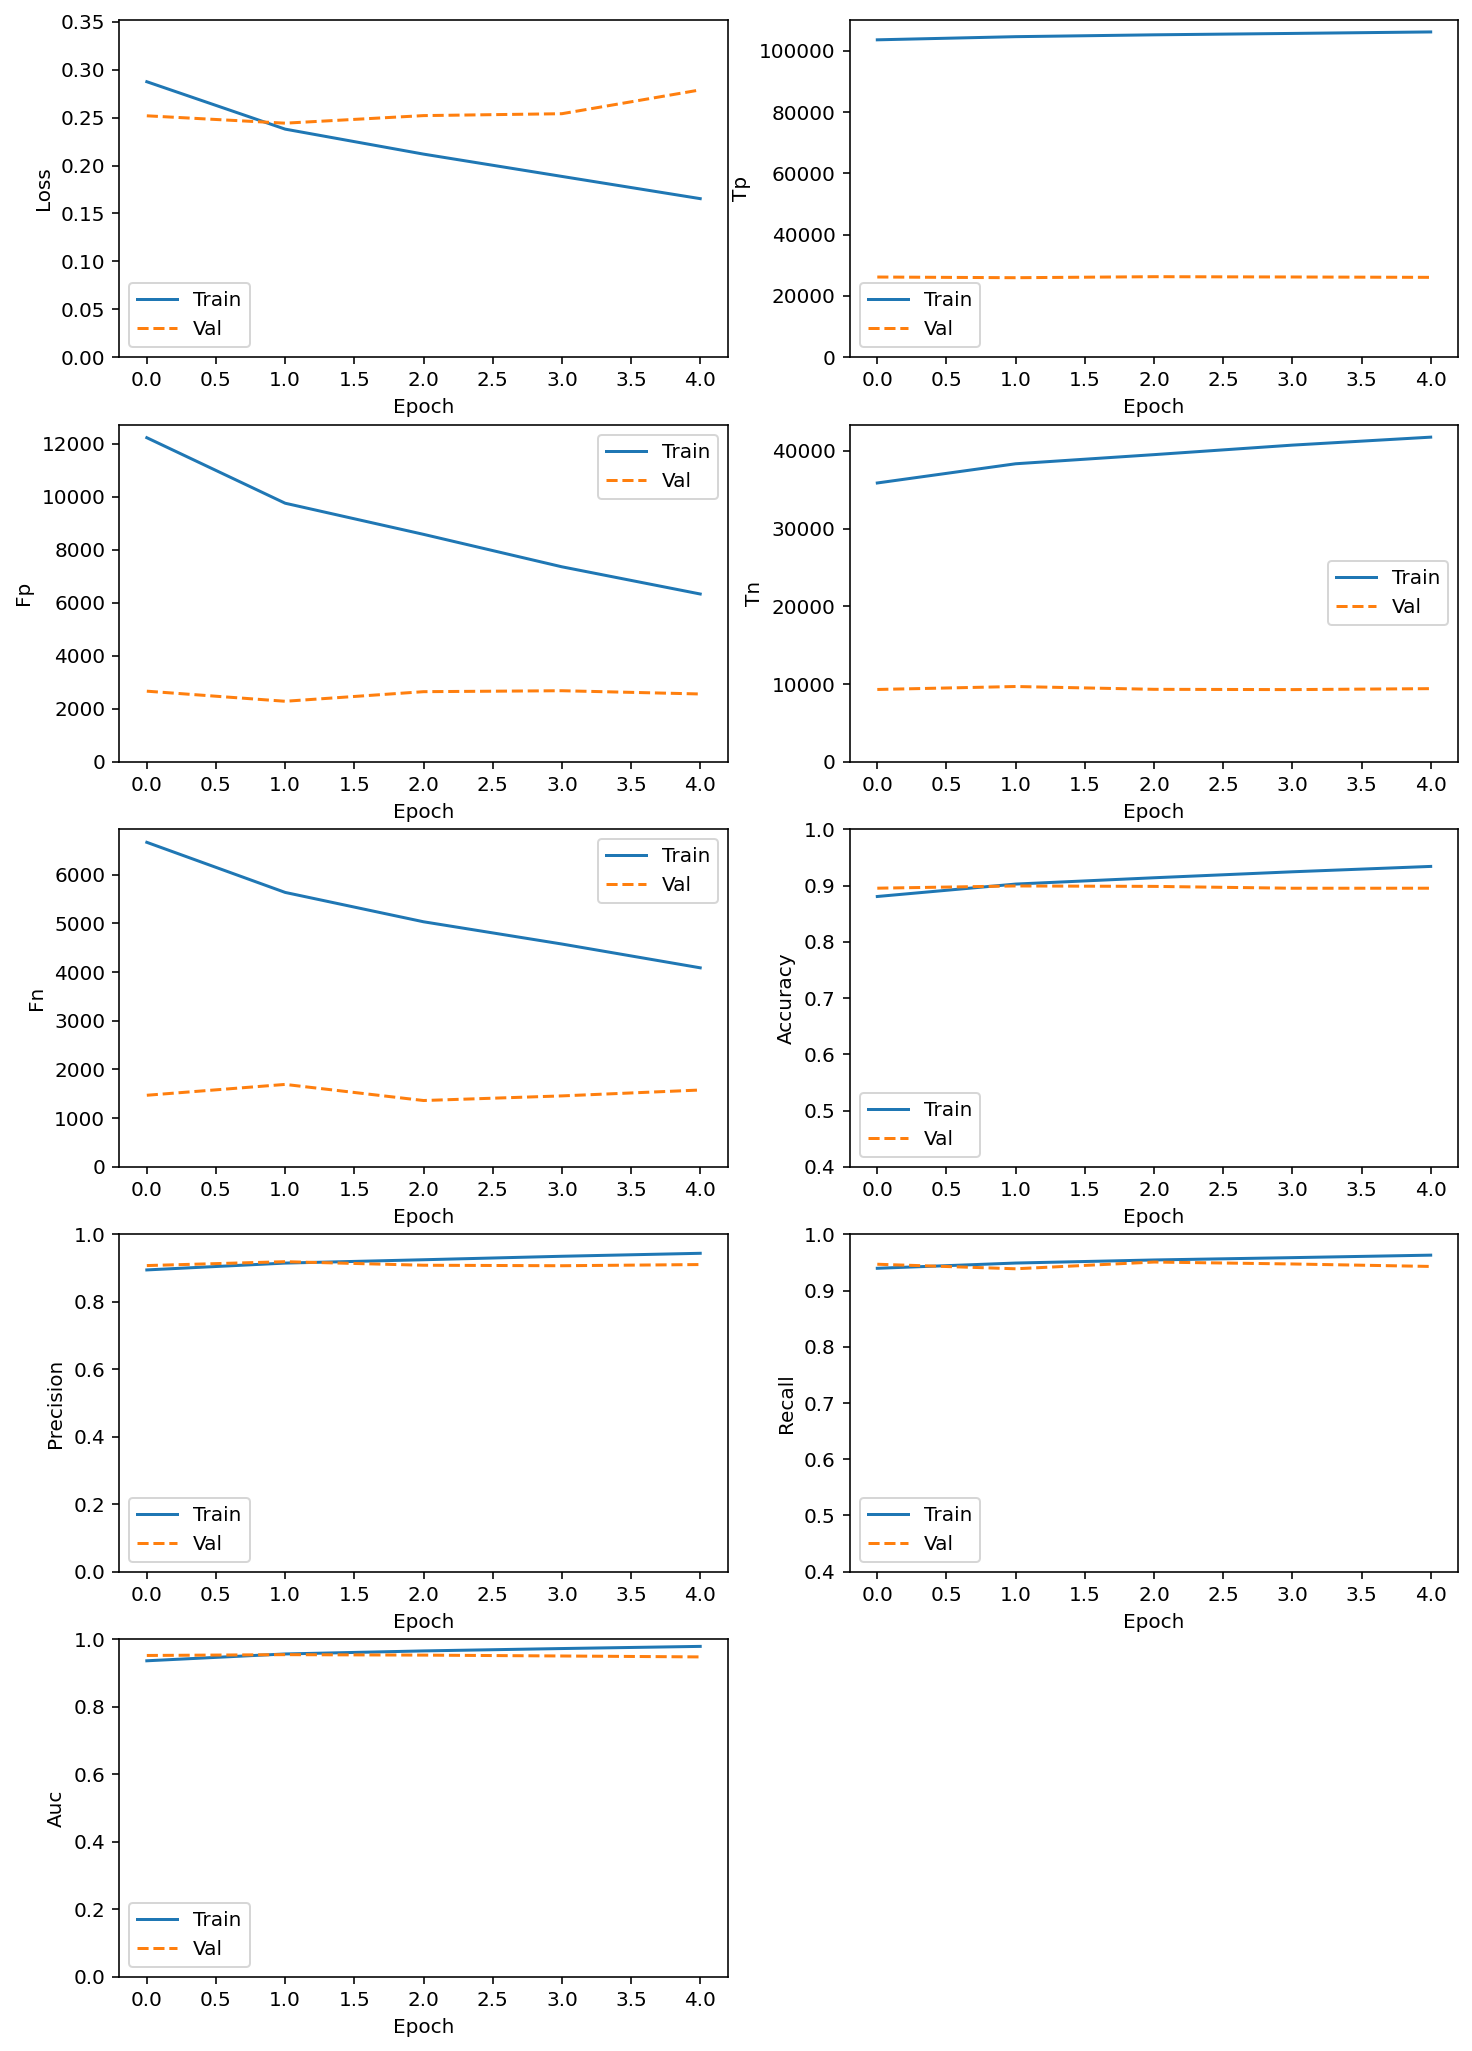

In [ ]:
#plt.style.use("fivethirtyeight")

# Cross Validation Classification Accuracy

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)

def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

plot_metrics(history)

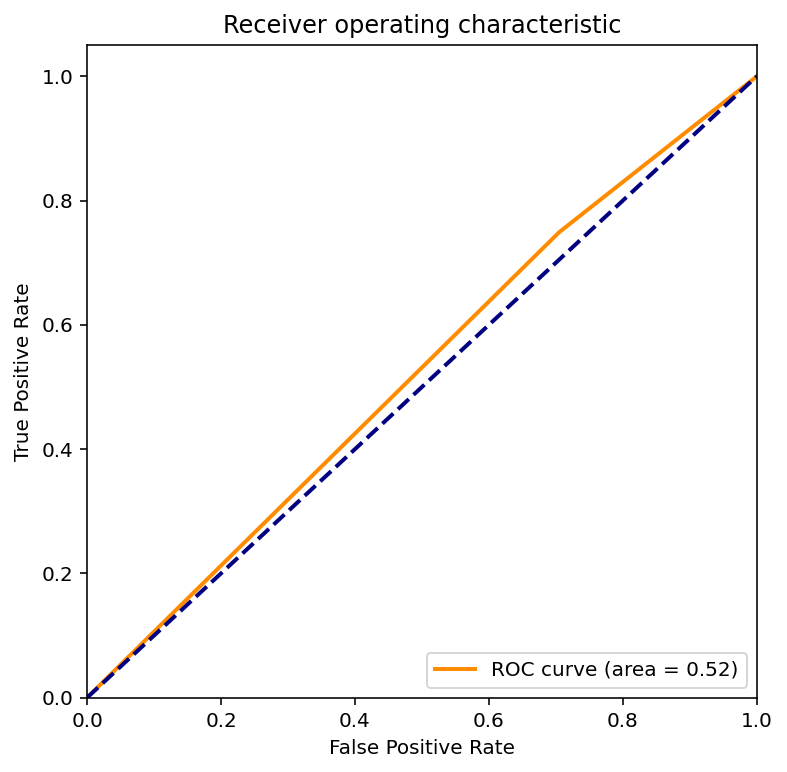

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

mpl.rcParams["figure.figsize"] = (6, 6)

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()